In [1]:
import cv2
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
import time 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Conv2DTranspose # = Deconvolution2D
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import concatenate, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.backend as K
import os
import time
from imagePreprocess import getImagesVarAndMean

data/resized/000034.jpg


In [2]:
# %load_ext blackcellmagic
# todo custom loss to bump up brigtness
isDataset2 = False
continueTrain = True
dataDir = "data/stl10/" if isDataset2 else "data/resized/"
biggerNet = True
depthMultiplier = 2
initializer = 'he_normal'#'glorot_uniform' ##
activation = 'relu'#LeakyReLU(alpha=0.3)
finalActivation = 'relu' # 'sigmoid'
normalize = finalActivation == 'sigmoid' # normalizing output hinders this training
colorspace = ['lab','rgb','hsv'][0]
rgb = colorspace == 'rgb'
lab = colorspace == 'lab'
trainSplitPercent = 0.8 # 0.8
valSplitPercent = 0.02 # 0.02


data_IDs = os.listdir(dataDir)
print('dataset size',len(data_IDs))
trainSize = int(len(data_IDs)*trainSplitPercent)

dataset size 202599


In [3]:
def showHsv(img):    
    if rgb:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    elif lab:
        img = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)
    else:
        img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
    plt.imshow(img)
    plt.show()

def customLoss(yTrue, yPred):
    # cyclic loss
    hueTrue = yTrue[...,0]
    huePred = yPred[...,0]
    maxHue = 180
#     hue = K.square(huePred - hueTrue) 
    
    hue2 = K.minimum(K.square(huePred - hueTrue), 
                    K.minimum(K.square(huePred - hueTrue + maxHue), 
                              K.square(huePred - hueTrue - maxHue)))
    #hue = K.minimum((huePred + 181 - hueTrue) % 181, (hueTrue + 181 - huePred) % 181) #3
    #hue = K.square( (huePred - hueTrue) % 181 )
    satDiff = yPred[...,1] - yTrue[...,1]
    # double loss for undershooting saturation
    # if sign is + then mul is 2, if sign is - mul is 2
    mul1or2 = (-K.sign(satDiff) +1)*2 + 1 # was /2
    saturation =  mul1or2*K.square(satDiff)
    #saturation = K.square(satDiff)
    #hue = hue  + 1 / (huePred + 1)
    #hue2 = hue2  + 1 / (huePred + 1)
    return K.concatenate([hue2, saturation], axis=-1) # predictedHue was 0 when order is reversed

def saturationLoss(yTrue, yPred):
    multiplier = 1 / K.sqrt(K.abs( (yPred[...,0] - 128) * (yPred[...,1] - 128)) +0.1)
    a =  K.square(yTrue[...,0] - yPred[...,0]) 
    b =  K.square(yTrue[...,1] - yPred[...,1]) 
    return K.concatenate([a*multiplier, b*multiplier], axis=-1)
    
def mapOutOfGreen(m):
    '''maps green colors into others'''
    minGreen, maxGreen = 42, 63
    target = 160
    r = np.copy(m)
    r[(r >= minGreen) & (r<=maxGreen)] = (r[(r >= minGreen) & (r<=maxGreen)] - minGreen) +  target
    # smoother transition
    d = 7
    lower = minGreen - d
    sel = r[(r < minGreen) & (r>= lower)]
    r[(r < minGreen) & (r>= lower)] = (sel - lower) /d * (target - lower) + sel

    higher = maxGreen + d
    sel = r[(r > maxGreen) & (r<= higher)]
    r[(r > maxGreen) & (r<= higher)] = (sel - higher) /d * (target - higher) + sel
    return r

def showImgFromPredict(hs, v, showDetails=False):
    '''shows h/s/v and complete image
    hs- a list containing hue and saturation matrices
    v - value matrix.
    all three should be uint8
    '''
    if rgb:
        RGB, v = hs[0], v[0,...,0]
        print('rgb.shape',RGB.shape)
        img = cv2.cvtColor(RGB, cv2.COLOR_BGR2RGB)
    else:
        hs, v = hs[0], v[0,...,0]
        #print('hs:',hs.shape)
        h, s = hs[...,0], hs[...,1]
        #h = mapOutOfGreen(h)
        #print('h',h.shape,'s',s.shape,'v',v.shape)
        #print(h.dtype, s.dtype, v.dtype)
        hsv = cv2.merge([v,h,s] if lab else [h,s,v] )
        img = cv2.cvtColor(hsv, cv2.COLOR_LAB2RGB if lab else cv2.COLOR_HSV2RGB)
    if not showDetails:
        plt.imshow(img)
        plt.show()
        return
        
    f, axarr = plt.subplots(1,4 + 1*rgb, figsize=(15,15))
    axarr[0].set_xticks([])
    axarr[0].set_yticks([])
    axarr[0].imshow(img)
    titles = ['blue', 'green', 'red','value'] if rgb else ['A','B','L'] if lab else ['hue', 'saturation', 'value']
    for i in range(3 if rgb else 2,-1,-1):
        if rgb:
            pic = RGB[:,:,i] if i < 3 else v
        elif lab:
            pic = hsv[:,:,-i-1]
        else:
            pic = hsv[:,:,i]
        axarr[1+i].title.set_text(titles[i])
        axarr[1+i].set_xticks([])
        axarr[1+i].set_yticks([])
        axarr[1+i].imshow(pic, cmap='gray')
    plt.show()
    
def predictFromImage(img, showDetails=False):
    '''processes input img, makes prediction from its value,
    and shows resulting image, hue, saturation and value'''
    inX, inY = loadImg(img )
    inX, inY = inX[None,...,None], inY[None,:]

    X, Y = inX, inY
    # 1st layer is hue, 2nd saturation
    predY = model.predict(X)
    if not rgb:
        print('predy',predY.min(), predY.max(), predY.mean() ,predY.shape)
        print(f'{"A" if lab else "hue"}:', predY[...,0].min(), predY[...,0].max(), predY[...,0].mean() )
        print(f'{"B" if lab else "sat"}:', predY[...,1].min(), predY[...,1].max(), predY[...,1].mean() )
    else:
        print('predy',predY.min(), predY.max(), predY.mean() ,predY.shape)
        print('red:',predY[...,2].min(), predY[...,2].max(), predY[...,2].mean() )
        print('green:',predY[...,1].min(), predY[...,1].max(), predY[...,1].mean() )
        print('blue:',predY[...,0].min(), predY[...,0].max(), predY[...,0].mean() )
    if normalize:
        # hue and sat [0,1] -> their range
        predY[...,0] *= 180
        predY[...,1] *= 255
    else:
        if not rgb:
            predY[...,0] = predY[...,0] % 181
        else:
            predY = np.minimum(predY, 255)
        predY = np.maximum(predY, 0)
    X = X.astype('uint8')
    predY = predY.astype('uint8')
    print('predy uint8',predY.min(), predY.max(), predY.mean() )
    if not rgb:
        hue = predY[...,0]
        print(f'{"A" if lab else "hue"} uint8', hue.min(), hue.max(), hue.mean() )

    showImgFromPredict(predY, X, showDetails)
    
def predictions(start=trainSize+98, count=10):
    '''display count predictionst, beginning from start'''
    for i in range(start,start+count):
        fname = f'data/stl10/unlabeled_image_png_{i}.png' if isDataset2 else f'data/resized/{i:06}.jpg'
        predictFromImage(fname, True) 

In [4]:
print("OpenCV uses H: 0 - 180, S: 0 - 255, V: 0 - 255")
img_in = cv2.imread('pic.jpg')
hsv = cv2.cvtColor(img_in, cv2.COLOR_BGR2LAB if lab else cv2.COLOR_BGR2HSV)
print(hsv.shape)
print('''LAB:
In CV2 for 8bit images, the range of all 3 channels is [0-255]
It has the following properties.

Perceptually uniform color space which approximates how we perceive color.
Independent of device ( capturing or displaying ).
Used extensively in Adobe Photoshop.
Is related to the RGB color space by a complex transformation equation.''')
h,s,v = cv2.split(hsv)
#print('s',s.shape)
s = (np.random.random(s.shape) * 255).astype('uint8')
h = (np.random.random(s.shape) * 180).astype('uint8')
#s = np.maximum(0, v)
#print(s)
hsv2 = cv2.merge([h,s,v])
# print('image with its value untouched, but saturation and hue randomized:');showHsv(hsv2); showHsv(hsv)

OpenCV uses H: 0 - 180, S: 0 - 255, V: 0 - 255
(1008, 1600, 3)
LAB:
In CV2 for 8bit images, the range of all 3 channels is [0-255]
It has the following properties.

Perceptually uniform color space which approximates how we perceive color.
Independent of device ( capturing or displaying ).
Used extensively in Adobe Photoshop.
Is related to the RGB color space by a complex transformation equation.


In [5]:
def loadImg(path):
    '''
    returns X - value
            Y - (hue, saturation) or (blue, green, red) or (L, A, B)
    '''
    img_in = cv2.imread(path)
    if lab:
        LAB = cv2.cvtColor(img_in, cv2.COLOR_BGR2LAB)
        l,a,b = cv2.split(LAB)
        return l, np.dstack((a,b))
        
    hsv = cv2.cvtColor(img_in, cv2.COLOR_BGR2HSV)
    h,s,v = cv2.split(hsv)
    X = v
    if rgb:
        b,g,r = cv2.split(img_in)
        Y = np.dstack((b,g,r))
    else:
        Y = np.dstack((h,s))
    #print("loadX.shape", X.shape, 'loadY.shape', Y.shape)
    return X, Y

# celebA dataset from https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg
# 202,599 images of size 178x218
# in /resized/ they are cropped to be 128x128

# stl10 dataset from https://www.kaggle.com/jessicali9530/stl10
# 100,000 images of size 96x96

# data generator for feeding into memory parts of dataset
class DataGenerator(tf.keras.utils.Sequence):
    'data generator for feeding into memory parts of dataset'
    def __init__(self, list_IDs, dim, batch_size=32, in_channels=1,
                 out_channels=2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.shuffle = shuffle
        self.on_epoch_end()
#         self.hsstd = np.sqrt(var[...,:2])
#         self.hsmean = mean[...,:2]
#         self.vstd = np.sqrt(var[...,2])
#         self.vmean = mean[...,2]

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, Y = self.__data_generation(list_IDs_temp)

        return X, Y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim))
        # target 2 channels
        Y = np.empty((self.batch_size, *self.dim, self.out_channels))
        # print(X.shape, Y.shape)
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i], Y[i] = loadImg(dataDir + ID)
#         print('X[i].shape:',X[0].shape)
#         print('X.shape:',X.shape,'Y.shape',Y.shape)
        #X = (X - self.vmean)/self.vstd # it doesn't like standardization 
        X = np.expand_dims(X, axis=len(X.shape))
        if normalize:
            Y[...,0] /= 180 # was [0] by mistake
            Y[...,1] /= 255
#             X /= 255
#         print('X[i].shape:',X[0].shape)
#         print('X.shape:',X.shape,'Y.shape',Y.shape)
        return X, Y

In [6]:
params = {'dim': (96, 96) if isDataset2 else (128, 128),
          'batch_size': 32,
          'in_channels': 1,
          'out_channels': 3 if rgb else 2,
          'shuffle': True}
train_IDs = data_IDs[:trainSize]
print('train len', len(train_IDs))
valSize = int(len(data_IDs)*valSplitPercent)
splitValAt = int(trainSize + valSize)
val_IDs = data_IDs[trainSize:splitValAt]
print('val len', len(val_IDs))

# params['var'], params['mean'] = getImagesVarAndMean([dataDir + x for x in train_IDs], params['dim'] + (3,))

training_generator = DataGenerator(train_IDs, **params)
validation_generator = DataGenerator(val_IDs, **params)
print(training_generator[0][1].shape)

train len 162079
val len 4051
(32, 128, 128, 2)


In [7]:
def createModel(input_shape, bigger, mul, initializer, activation, finalActivation):
    input_shape = input_shape + (1,)
    inputs = Input(input_shape)
    
    conv1 = Conv2D(16*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(inputs)
    if bigger:
        conv1 = Conv2D(16*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(32*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(pool1)
    if bigger:
        conv2 = Conv2D(32*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(64*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(pool2)
    if bigger:
        conv3 = Conv2D(64*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(64*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(pool3)
    if bigger:
        conv4 = Conv2D(64*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(conv4)
    
    up5 = Conv2D(64*mul, 2, activation = activation, padding = 'same')(UpSampling2D(size = (2,2))(conv4))
    merge5 = concatenate([conv3, up5], axis=3)
    conv5 = Conv2D(64*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(merge5)
    if bigger:
        conv5 = Conv2D(64*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(conv5)
    
    up6 = Conv2D(32*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(UpSampling2D(size = (2,2))(conv5))
    merge6 = concatenate([conv2, up6], axis=3)
    conv6 = Conv2D(32*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(merge6)
    if bigger:
        conv6 = Conv2D(64*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(conv6)
    
    up7 = Conv2D(16*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv1, up7], axis=3)
    conv7 = Conv2D(16*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(merge7)
    conv7 = Conv2D(16*mul, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(conv7)
    conv7 = Conv2D(4, 3, activation = activation, padding = 'same', kernel_initializer=initializer)(conv7)
    # Stride 1 deconvolutions — which we often see as the last layer in successful models 
    conv7 = Conv2D(3 if rgb else 2, 1, activation = finalActivation, padding = 'same', kernel_initializer=initializer)(conv7)
    
    model = Model(inputs=inputs, outputs=conv7)
    
    model.compile(loss='mean_squared_error',#customLoss,
                  optimizer=tf.keras.optimizers.Adam(lr=0.001), 
                  metrics=['mae','mse'])
    return model

model = createModel(params['dim'], biggerNet, depthMultiplier, initializer, activation, finalActivation)
model.summary()
print(model.output_shape)

Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 32)   0           conv2d_1[0][0]                   
____________________________

In [8]:
currTime = time.strftime("%d-%m-%Y-%H-%M-%S", time.localtime())
layers = ['unet', 'bigger' if biggerNet else 'smaller', f'mul{depthMultiplier}', initializer]
NAME = "_".join(str(l) for l in layers) + f"{ currTime }"
print(NAME)
model = createModel(params['dim'], biggerNet, depthMultiplier, initializer, activation, finalActivation)
tensorboard = TensorBoard(log_dir=f'logs/{NAME}')
if continueTrain:
    countEpochs = 1
    model.load_weights('data/lab_big_train_set.h5')
else:
    model.fit_generator(generator=training_generator,
                        validation_data=validation_generator,
                        epochs=1,
                        use_multiprocessing=False,
                        workers=0,
                        callbacks=[tensorboard])
    countEpochs = 1
#Compiling a model does not modify its state. Weights after compilation are the same as before compilation.
# predictions(trainSize, 10)

unet_bigger_mul2_he_normal08-06-2019-16-04-24


In [28]:
# model.load_weights('data/unet_bigger_mul1_glorot_uniform13-05-2019-00-47-35.h5')
# model.save_weights('lab_fully_trained.h5')
# model.load_weights('data/stl.h5')

Epoch 7/7
5064/5064 [==============================] - 1295s 256ms/step - loss: 106.8101 - mean_absolute_error: 6.7643 - mean_squared_error: 106.8101 - val_loss: 99.0928 - val_mean_absolute_error: 6.3592 - val_mean_squared_error: 99.0928
predy 125.87985 153.68011 139.28815 (1, 128, 128, 2)
A: 127.67073 153.68011 138.24474
B: 125.87985 153.42026 140.33157
predy uint8 125 153 138.78546142578125
A uint8 127 153 137.7413330078125


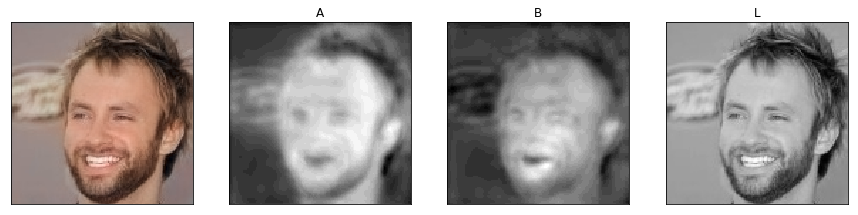

Epoch 8/8
5064/5064 [==============================] - 1295s 256ms/step - loss: 105.5684 - mean_absolute_error: 6.7056 - mean_squared_error: 105.5684 - val_loss: 100.2506 - val_mean_absolute_error: 6.5456 - val_mean_squared_error: 100.2506
predy 125.366455 156.8336 137.82224 (1, 128, 128, 2)
A: 125.366455 156.8336 135.32161
B: 125.93878 151.8677 140.32286
predy uint8 125 156 137.3245849609375
A uint8 125 156 134.82366943359375


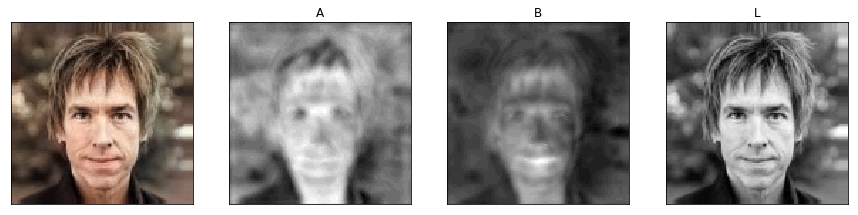

In [26]:
best = 100.3095
for i in range(1,10):
    #start_time = time.time()
    hist = model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    initial_epoch=countEpochs, # for tensorflow graph continuation
                    epochs=countEpochs+1,
                    use_multiprocessing=False,
                    workers=0,
                    callbacks=[tensorboard])
    countEpochs+=1
    #elapsed_time = time.time() - start_time
    #print(f"epochs:{countEpochs}, elapsed time:{elapsed_time}")
    predictions(trainSize+i, 1)
    last = hist.history['val_loss'][-1]
    if best < last:
        break
    best = last
    model.save_weights(f'lab_fully_trained{i}.h5')

countEpochs 8
predy 126.03835 160.25763 138.75064 (1, 128, 128, 2)
A: 126.03835 160.25763 137.2301
B: 128.27069 157.02176 140.27121
predy uint8 126 160 138.25119018554688
A uint8 126 160 136.73199462890625


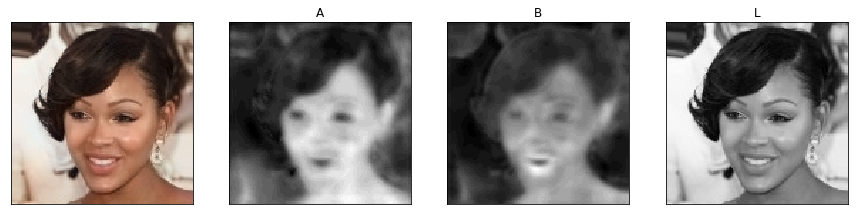

predy 125.96117 157.46068 138.59505 (1, 128, 128, 2)
A: 129.64964 156.23033 139.09521
B: 125.96117 157.46068 138.09488
predy uint8 125 157 138.09161376953125
A uint8 129 156 138.5914306640625


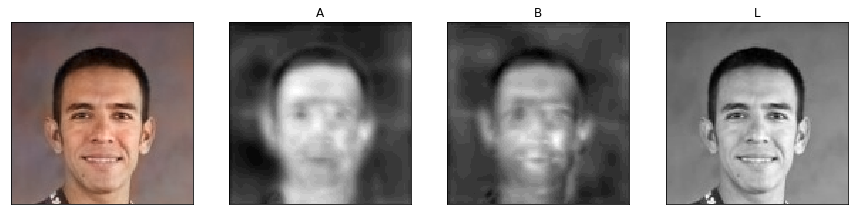

predy 124.1922 156.81264 139.1296 (1, 128, 128, 2)
A: 126.22852 156.81264 137.61185
B: 124.1922 156.5564 140.64734
predy uint8 124 156 138.63290405273438
A uint8 126 156 137.1058349609375


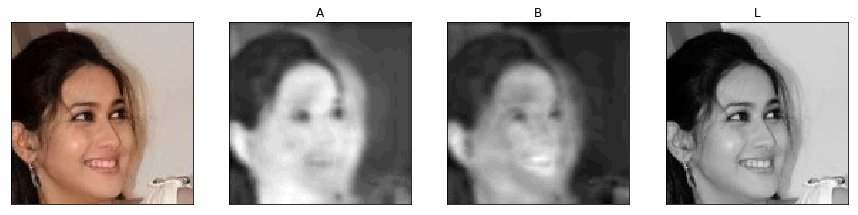

predy 127.59296 164.68358 139.14148 (1, 128, 128, 2)
A: 127.59296 164.68358 136.50453
B: 129.49161 156.39621 141.77844
predy uint8 127 164 138.64205932617188
A uint8 127 164 136.00518798828125


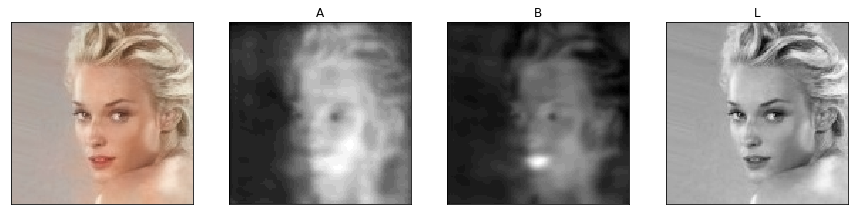

predy 126.39221 163.8176 140.01727 (1, 128, 128, 2)
A: 128.14247 163.8176 138.11684
B: 126.39221 157.62758 141.9177
predy uint8 126 163 139.50460815429688
A uint8 128 163 137.59808349609375


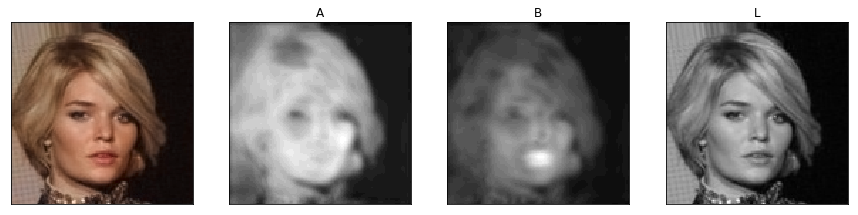

predy 123.92829 159.9427 138.41704 (1, 128, 128, 2)
A: 123.92829 159.9427 137.14276
B: 127.088974 155.13495 139.69131
predy uint8 123 159 137.91885375976562
A uint8 123 159 136.64373779296875


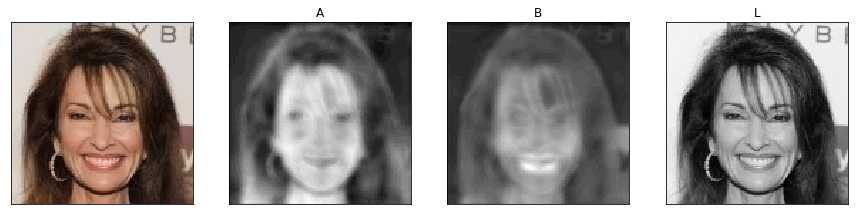

predy 125.85538 152.52275 136.94415 (1, 128, 128, 2)
A: 125.85538 150.80743 137.19925
B: 127.06305 152.52275 136.68906
predy uint8 125 152 136.44338989257812
A uint8 125 150 136.69622802734375


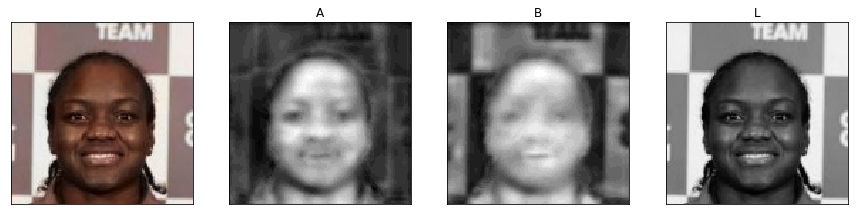

predy 123.82692 162.14694 139.90579 (1, 128, 128, 2)
A: 123.82692 162.14694 137.23685
B: 127.72209 155.51581 142.5747
predy uint8 123 162 139.40689086914062
A uint8 123 162 136.7369384765625


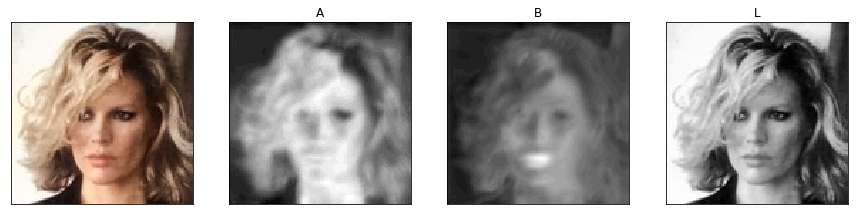

predy 122.401474 154.16473 133.67397 (1, 128, 128, 2)
A: 124.64851 148.73557 133.68048
B: 122.401474 154.16473 133.66742
predy uint8 122 154 133.17605590820312
A uint8 124 148 133.18560791015625


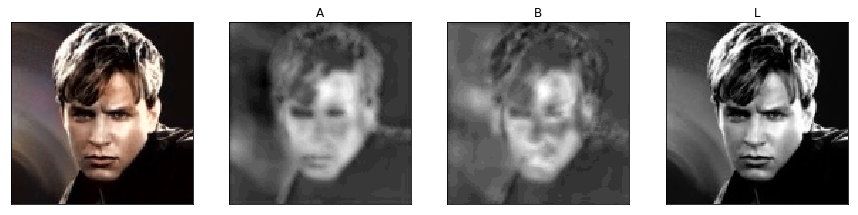

predy 127.02165 162.11824 138.80334 (1, 128, 128, 2)
A: 129.29187 162.11824 137.9946
B: 127.02165 156.50114 139.61206
predy uint8 127 162 138.30514526367188
A uint8 129 162 137.496826171875


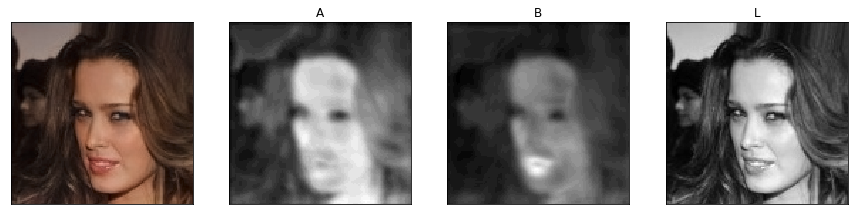

predy 125.85788 157.06992 137.29617 (1, 128, 128, 2)
A: 125.85788 157.06992 135.48296
B: 127.77334 153.24924 139.1094
predy uint8 125 157 136.79470825195312
A uint8 125 157 134.98773193359375


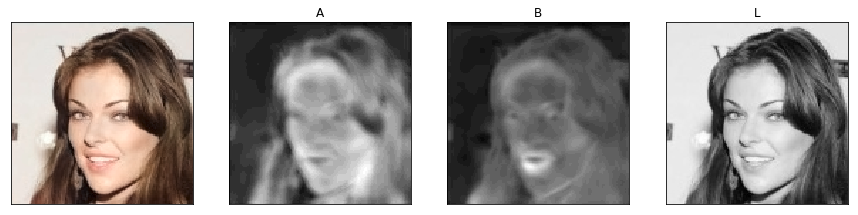

predy 125.773155 157.02283 138.47818 (1, 128, 128, 2)
A: 125.773155 156.65881 137.76201
B: 127.64398 157.02283 139.19435
predy uint8 125 157 137.97607421875
A uint8 125 156 137.257568359375


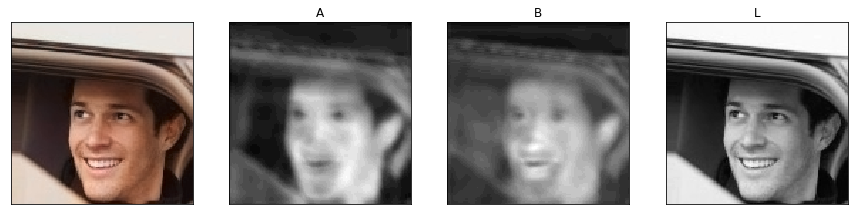

predy 127.164406 159.96443 139.8276 (1, 128, 128, 2)
A: 129.78242 155.54692 139.68314
B: 127.164406 159.96443 139.97206
predy uint8 127 159 139.32806396484375
A uint8 129 155 139.184326171875


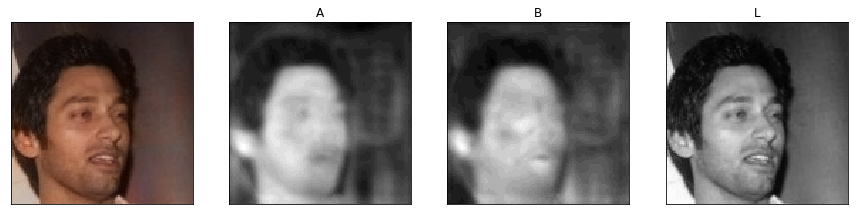

predy 128.22696 156.45468 138.72717 (1, 128, 128, 2)
A: 128.22696 151.05898 137.04152
B: 128.68266 156.45468 140.41281
predy uint8 128 156 138.23150634765625
A uint8 128 151 136.54559326171875


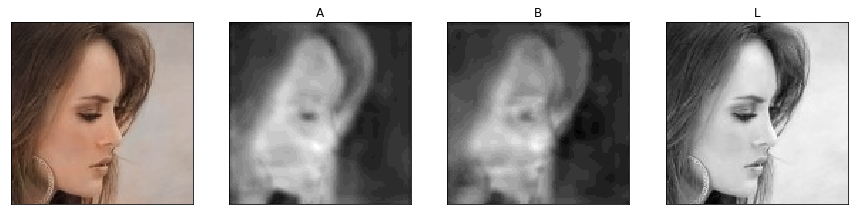

predy 126.01071 156.05038 141.44199 (1, 128, 128, 2)
A: 126.01071 156.05038 138.06113
B: 131.00127 154.47057 144.82283
predy uint8 126 156 140.94097900390625
A uint8 126 156 137.56298828125


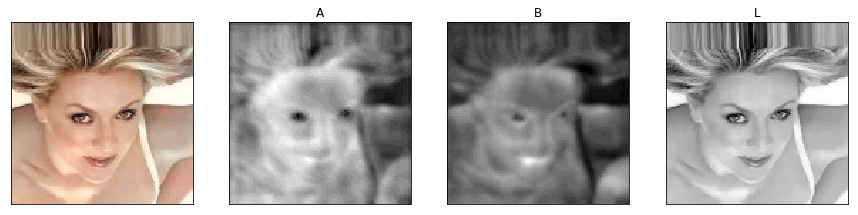

predy 125.28494 156.82396 138.27203 (1, 128, 128, 2)
A: 125.28494 154.36403 136.9071
B: 127.997856 156.82396 139.63696
predy uint8 125 156 137.77627563476562
A uint8 125 154 136.41015625


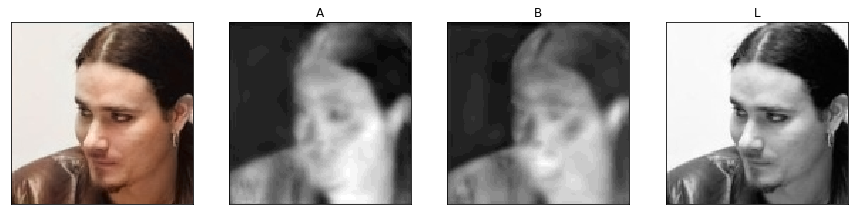

predy 124.32407 155.6075 134.59534 (1, 128, 128, 2)
A: 125.92402 151.45056 133.95282
B: 124.32407 155.6075 135.23785
predy uint8 124 155 134.09671020507812
A uint8 125 151 133.45623779296875


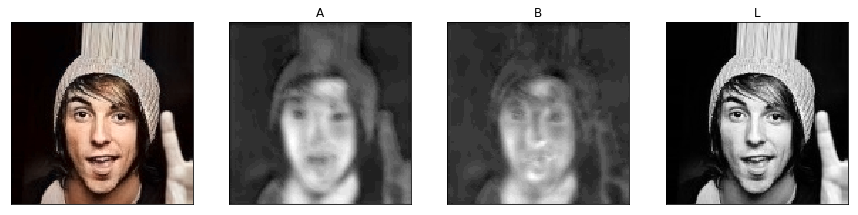

predy 124.80329 165.53542 136.21371 (1, 128, 128, 2)
A: 124.80329 165.53542 134.8114
B: 125.62444 154.69832 137.61603
predy uint8 124 165 135.71566772460938
A uint8 124 165 134.3115234375


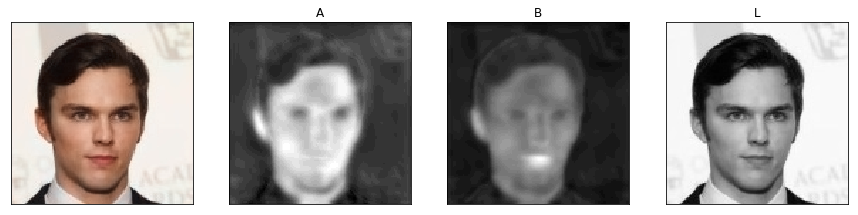

predy 124.22128 159.37166 142.16469 (1, 128, 128, 2)
A: 125.10361 159.37166 139.72612
B: 124.22128 156.11626 144.60327
predy uint8 124 159 141.66744995117188
A uint8 125 159 139.227294921875


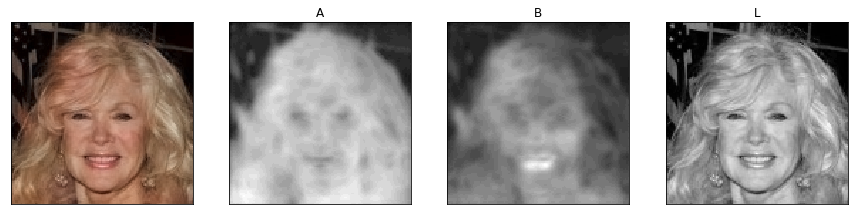

predy 125.93433 158.77621 137.1549 (1, 128, 128, 2)
A: 127.84646 158.77621 135.94377
B: 125.93433 154.55568 138.36606
predy uint8 125 158 136.65969848632812
A uint8 127 158 135.44036865234375


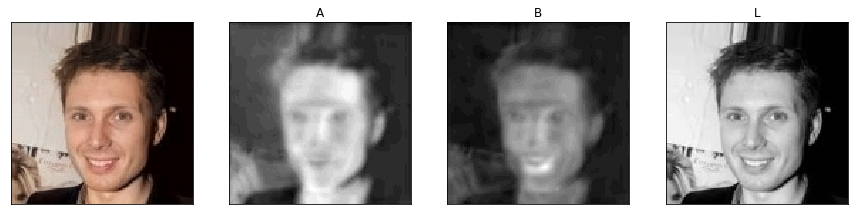

predy 126.46862 154.43198 138.43495 (1, 128, 128, 2)
A: 126.46862 154.43198 137.1983
B: 127.35542 152.77818 139.6716
predy uint8 126 154 137.9368896484375
A uint8 126 154 136.699462890625


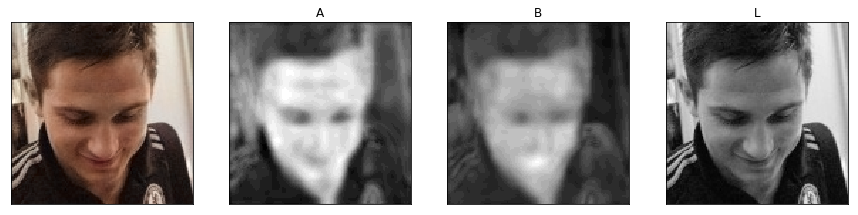

predy 126.60992 153.85817 139.08896 (1, 128, 128, 2)
A: 127.48255 153.85817 137.99733
B: 126.60992 152.28693 140.1806
predy uint8 126 153 138.57989501953125
A uint8 127 153 137.49066162109375


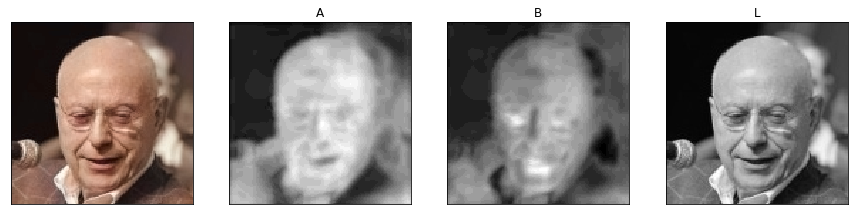

predy 127.975204 170.60002 142.81204 (1, 128, 128, 2)
A: 129.50798 170.60002 140.23659
B: 127.975204 156.18686 145.3875
predy uint8 127 170 142.31405639648438
A uint8 129 170 139.738037109375


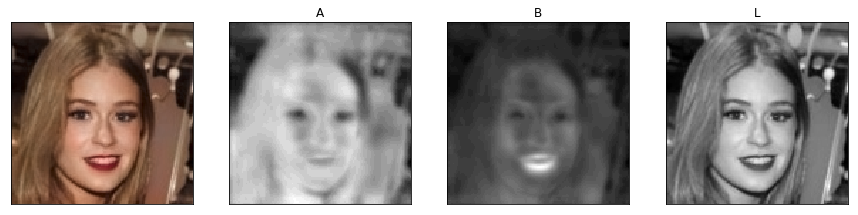

predy 125.8184 167.0394 136.97293 (1, 128, 128, 2)
A: 125.8184 167.0394 136.33206
B: 126.78053 155.97627 137.6138
predy uint8 125 167 136.47573852539062
A uint8 125 167 135.8375244140625


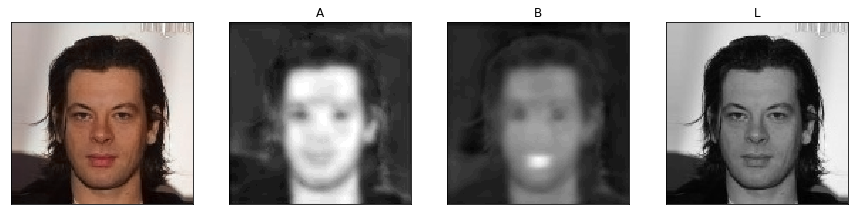

predy 124.05783 155.17888 136.64136 (1, 128, 128, 2)
A: 126.17237 154.38904 135.70386
B: 124.05783 155.17888 137.57887
predy uint8 124 155 136.1331787109375
A uint8 126 154 135.19696044921875


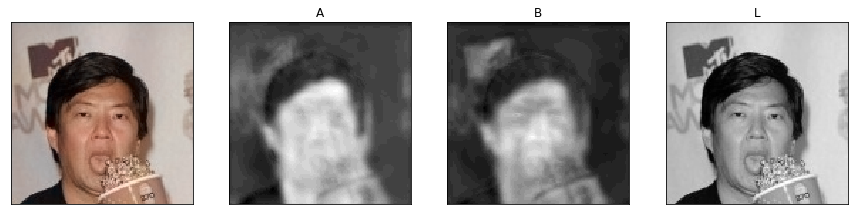

predy 126.1548 157.58763 136.5218 (1, 128, 128, 2)
A: 127.84392 157.58763 136.08444
B: 126.1548 155.07384 136.95917
predy uint8 126 157 136.01834106445312
A uint8 127 157 135.578125


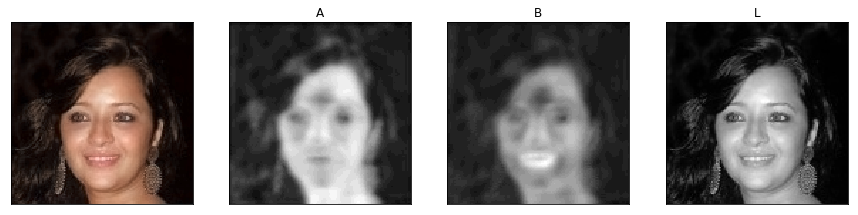

predy 126.92607 155.34074 138.09094 (1, 128, 128, 2)
A: 126.92607 153.7552 137.53668
B: 127.33628 155.34074 138.64519
predy uint8 126 155 137.59097290039062
A uint8 126 153 137.034423828125


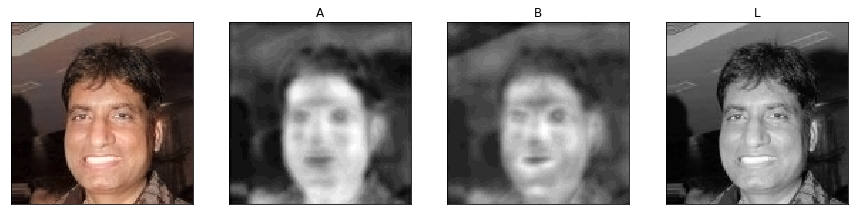

predy 124.4998 155.6621 136.07964 (1, 128, 128, 2)
A: 125.31356 155.03865 134.38263
B: 124.4998 155.6621 137.77664
predy uint8 124 155 135.5826416015625
A uint8 125 155 133.88922119140625


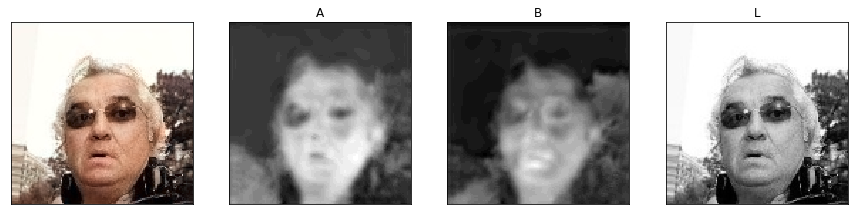

predy 127.23682 156.0284 141.17126 (1, 128, 128, 2)
A: 127.23682 150.91154 138.9018
B: 128.76979 156.0284 143.44073
predy uint8 127 156 140.67208862304688
A uint8 127 150 138.39849853515625


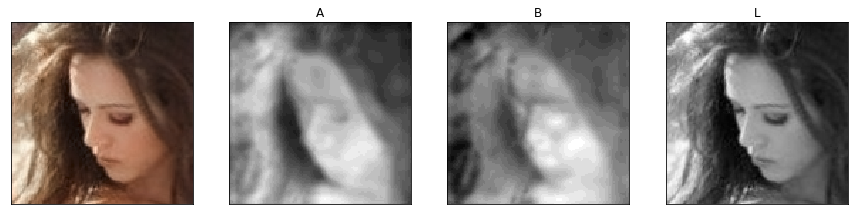

predy 126.13387 156.9311 137.24606 (1, 128, 128, 2)
A: 127.72245 153.38899 136.1857
B: 126.13387 156.9311 138.30643
predy uint8 126 156 136.74606323242188
A uint8 127 153 135.68328857421875


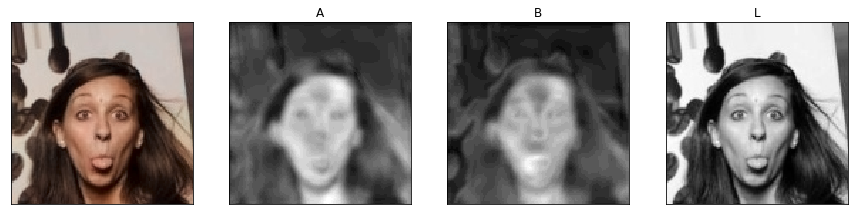

predy 127.03769 162.86911 140.58463 (1, 128, 128, 2)
A: 127.25008 162.86911 138.02371
B: 127.03769 155.62315 143.14551
predy uint8 127 162 140.08758544921875
A uint8 127 162 137.52862548828125


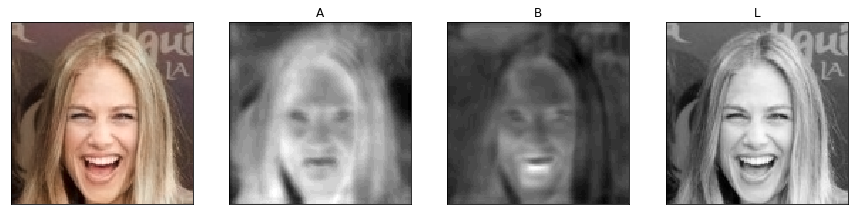

predy 125.362045 164.94757 139.7106 (1, 128, 128, 2)
A: 125.362045 164.94757 136.16568
B: 127.312645 159.78629 143.25554
predy uint8 125 164 139.20867919921875
A uint8 125 164 135.66436767578125


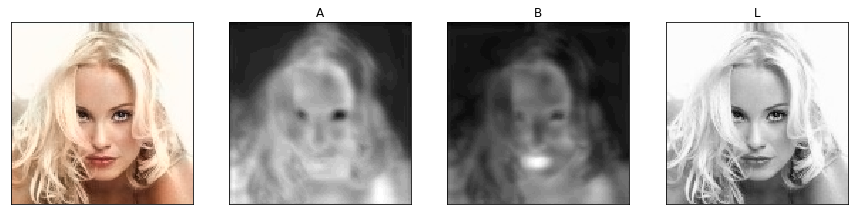

predy 125.81062 157.44997 134.86731 (1, 128, 128, 2)
A: 127.85601 157.44997 134.86021
B: 125.81062 155.7742 134.87437
predy uint8 125 157 134.36083984375
A uint8 127 157 134.3515625


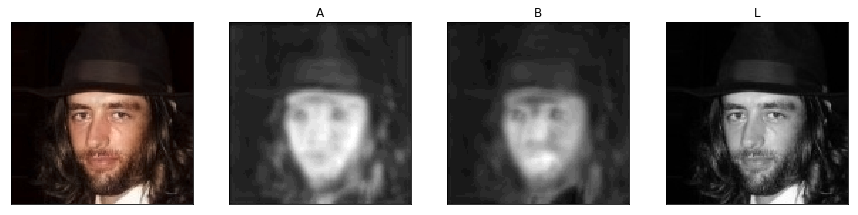

predy 125.7142 156.96692 138.86292 (1, 128, 128, 2)
A: 127.76399 154.15593 138.30617
B: 125.7142 156.96692 139.41965
predy uint8 125 156 138.35580444335938
A uint8 127 154 137.80181884765625


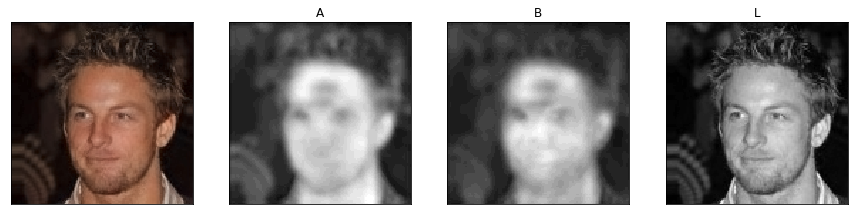

predy 122.77734 162.98491 137.16756 (1, 128, 128, 2)
A: 128.6437 162.98491 136.66861
B: 122.77734 155.55365 137.6665
predy uint8 122 162 136.67465209960938
A uint8 128 162 136.17730712890625


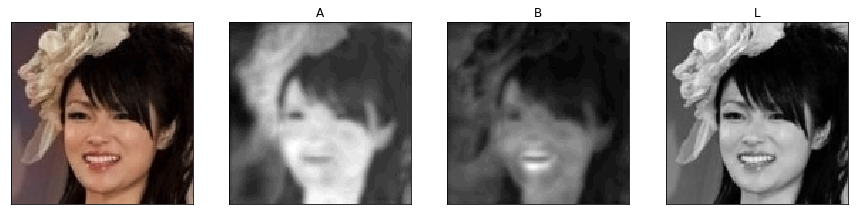

predy 127.10337 166.81876 141.0413 (1, 128, 128, 2)
A: 128.84671 166.81876 138.20036
B: 127.10337 160.44681 143.88226
predy uint8 127 166 140.54391479492188
A uint8 128 166 137.7015380859375


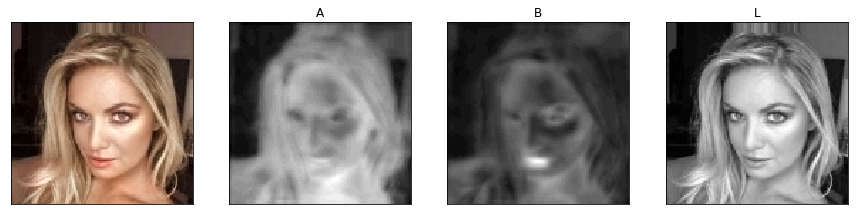

predy 125.7005 156.38766 137.58313 (1, 128, 128, 2)
A: 128.26039 156.38766 137.56937
B: 125.7005 154.33298 137.59688
predy uint8 125 156 137.08139038085938
A uint8 128 156 137.06622314453125


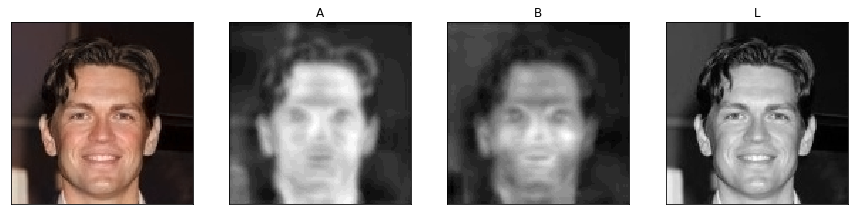

predy 128.84636 158.48547 141.82422 (1, 128, 128, 2)
A: 128.84636 158.48547 139.0387
B: 131.28922 154.59332 144.60976
predy uint8 128 158 141.32354736328125
A uint8 128 158 138.53680419921875


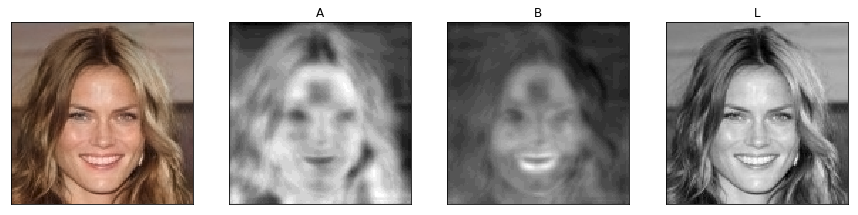

predy 128.52945 152.92368 138.32936 (1, 128, 128, 2)
A: 129.42543 152.18959 137.58563
B: 128.52945 152.92368 139.07309
predy uint8 128 152 137.83175659179688
A uint8 129 152 137.09033203125


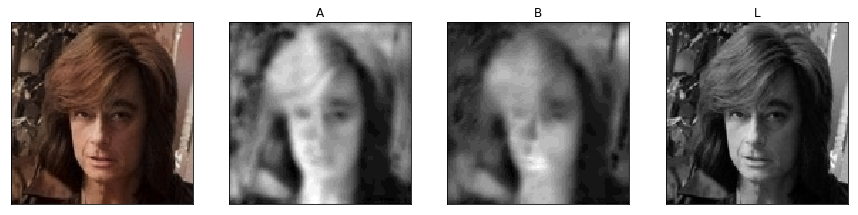

predy 125.69266 155.4528 137.57361 (1, 128, 128, 2)
A: 126.77653 151.37675 136.56534
B: 125.69266 155.4528 138.58191
predy uint8 125 155 137.07485961914062
A uint8 126 151 136.068359375


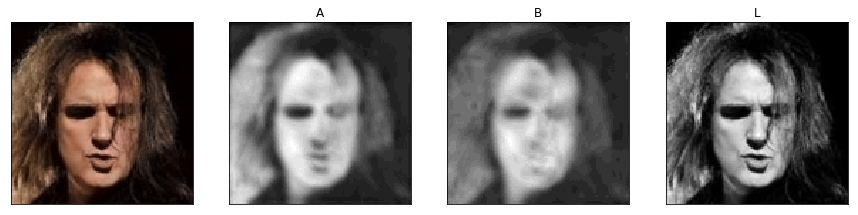

In [27]:
print('countEpochs',countEpochs)
predictions(trainSize+40, 40)


In [ ]:
def nonMlBaseline():
    x = training_generator[33][0][0,...,0]
    var, mean = getImagesVarAndMean([dataDir + idx for idx in train_IDs], params['dim'] + (3,))
    y = np.dstack([mean[...,0].astype('uint8'), mean[...,1].astype('uint8'), x.astype('uint8')])

    fig = plt.figure(figsize=(8,8))
    for i in range(1,4):
        fig.add_subplot(1,3,i)
        plt.title(['A','B','L'][i-1])
        plt.imshow(mean[...,i-1])
    plt.show()
    print("Input value with mean A and mean B:")
    showHsv(y)
nonMlBaseline()

In [ ]:
print("testing custom Loss:")
x = Input(shape=(None,))
y = Input(shape=(None,))
loss_func = K.function([x, y], [customLoss(x, y)])
loss_func([[[[1,1], [1,16] ]], [[[1,1], [1,14]]] ])

In [ ]:
model.save(f'data/{NAME}.h5')

In [ ]:
# print("OpenCV uses H: 0 - 180, S: 0 - 255, V: 0 - 255")
# batch=55
# print('testing channel ranges:')
# print(training_generator[batch][1][...,0].max(), training_generator[batch][1][...,0].min())
# print(training_generator[batch][1].shape)
# h = np.minimum(training_generator[batch][1][0,..., 0 ] + 0, 180).astype('uint8') 
# s = np.minimum(training_generator[batch][1][0,..., 1 ] + 0, 255).astype('uint8')
# v = training_generator[batch][0][0,...].astype('uint8')
# y = np.dstack([h , s, v ] )
# showHsv(y )
# print(h.min(), h.max())
# plt.imshow(h)

# show filters

# x1w = model.get_weights()[0][:,:,0,:]
# for i in range(1,26):
#   plt.subplot(5,5,i)
#   plt.imshow(x1w[:,:,i],interpolation="nearest",cmap="gray")
# plt.show()

In [ ]:
def demo(imgpath):
    img = cv2.imread(imgpath)
    img = cv2.resize(img, (128,128))
    cv2.imwrite("./tmp.jpg", img)
    predictFromImage("./tmp.jpg", True)
    try:
        os.remove("./tmp.jpg")
    except OSError:
        pass

In [ ]:
testSplit = int(trainSize + valSize)
test_IDs = data_IDs[testSplit:]
print('test len', len(val_IDs))
test_generator = DataGenerator(test_IDs, **params)
test_eval = model.evaluate_generator(test_generator)

In [ ]:
_ = [print (f'{x[0]}: {x[1]}') for x in zip(model.metrics_names, test_eval)]